In [1]:
import numpy as np
import nolds
import scipy.io
import mne
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
from scipy import stats
import matplotlib.pyplot as plt
import antropy as ent
from antropy import higuchi_fd
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.computation import RQAComputation
from pyrqa.time_series import TimeSeries
from pyrqa.result import RQAResult
from pyrqa.opencl import OpenCL
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.settings import Settings
from pyrqa.time_series import TimeSeries
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.image_generator import ImageGenerator
import numpy as np
import matplotlib.pyplot as plt
from antropy import higuchi_fd

In [2]:
mat = loadmat('/home/vincent/AAA projects/University/MSc AI/Final Project/downsampled/EEG_DS_Struct_0101.mat')

In [3]:
mat_variables = scipy.io.whosmat('/home/vincent/AAA projects/University/MSc AI/Final Project/downsampled/EEG_DS_Struct_0101.mat')

# Fractal Dimension Analysis

In [4]:
# Load data
data = loadmat('/home/vincent/AAA projects/University/MSc AI/Final Project/downsampled/EEG_DS_Struct_0101.mat')

In [5]:
print(type(data['DSamp']))  # check the data type
print(data['DSamp'].shape)  # check the shape of the data
print(data['DSamp'])  # print the data

<class 'numpy.ndarray'>
(1, 1)
[[(array([[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64)),
          (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64)),
          (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3')),
          (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64)),
          (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))

In [6]:
DSamp = data['DSamp']

triggers = DSamp[0][0][0]
EEGdata = DSamp[0][0][1]
fs = DSamp[0][0][2][0][0] 
fsOld = DSamp[0][0][3][0][0] 
time = DSamp[0][0][4][0]
label = DSamp[0][0][5]
nchan = DSamp[0][0][6][0][0]
rate = DSamp[0][0][7][0][0]
npt = DSamp[0][0][8][0][0]
Subj = DSamp[0][0][9][0]
ptrackerPerf = DSamp[0][0][10]
ptrackerTime = DSamp[0][0][11]
ptrackerfs = DSamp[0][0][12][0][0]

In [7]:
import pyqtgraph as pg
print(pg.__version__)



0.13.3


In [15]:
import pyqtgraph as pg
from pyqtgraph.Qt import QtGui, QtCore, QtWidgets

app = QtWidgets.QApplication([])

win = pg.GraphicsWindow()
win.setWindowTitle('Scrolling EEG Channels')

p = []
curves = []
data = []

num_channels = EEGdata.shape[0]
window_width = 1000

for ch in range(num_channels):
    p.append(win.addPlot())
    curves.append(p[ch].plot(pen='y'))
    data.append(np.empty(window_width))

def update():
    for ch in range(num_channels):
        data[ch][:-1] = data[ch][1:]
        data[ch][-1] = np.random.normal()
        curves[ch].setData(data[ch])

timer = QtCore.QTimer()
timer.timeout.connect(update)
timer.start(50)

QtWidgets.QApplication.instance().exec_()

AttributeError: module 'pyqtgraph' has no attribute 'GraphicsWindow'

In [7]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'DSamp'])


In [8]:
subjects_data = data['DSamp']  # This now represents multiple subjects

# Initialize an empty list to store the mean fractal dimension for each subject
fractal_dims_all_subjects = []
subjects_group = []  # Add this line to track the group assignments

# Loop over each subject's data
for subject_idx in range(subjects_data.shape[0]):
    print(f"Processing Subject {subject_idx}")  # Printout for tracking progress
    
    # Extract EEG data for the current subject
    EEG_data = subjects_data[subject_idx][0][1]

    # Reshape EEG data to 1D if necessary
    eeg_data = EEG_data.flatten()

    # Split the data into segments of equal length
    segment_length = int(0.10 * len(eeg_data))
    segments = [eeg_data[i:i+segment_length] for i in range(0, len(eeg_data), segment_length)]
    
    # Check if no segments exist or any segment is too short
    if not segments or len(segments[0]) < 2: 
        print(f"Subject {subject_idx} has insufficient data.")
        continue
    
    # If no segments exist or any segment is too short, continue to the next subject
    if not segments or len(segments[0]) < 2: 
        print(f"Subject {subject_idx} has insufficient data.")
        continue
    
    # Calculate the fractal dimension of each segment
    try:
        fractal_dims = [nolds.dfa(segment) for segment in segments if len(segment) >= 2]
    except ValueError:
        print(f"Subject {subject_idx} cannot calculate DFA.")
        continue

    # Calculate the mean fractal dimension across all segments
    mean_fractal_dim = np.mean(fractal_dims)
    
    # Store the mean fractal dimension in the list
    fractal_dims_all_subjects.append(mean_fractal_dim)
    
    # Use the mean fractal dimension to stratify the subject
    if mean_fractal_dim < 1.2:  
        print(f"Subject {subject_idx} belongs to group A")
        subjects_group.append('A')  # Add this line to track the group assignments
    else:
        print(f"Subject {subject_idx} belongs to group B")
        subjects_group.append('B')  # And this line too

# Convert to a numpy array for convenience
fractal_dims_all_subjects = np.array(fractal_dims_all_subjects)
subjects_group = np.array(subjects_group)  # Convert this to a numpy array too

# Print some basic statistics
print(f"Mean fractal dimension across all subjects: {np.mean(fractal_dims_all_subjects)}")
print(f"Standard deviation of fractal dimension across all subjects: {np.std(fractal_dims_all_subjects)}")

# Histogram of the fractal dimensions
sns.histplot(fractal_dims_all_subjects, bins=10, kde=True)
plt.xlabel('Fractal Dimension')
plt.ylabel('Count')
plt.title('Histogram of Fractal Dimensions across all subjects')
plt.show()

# Perform a statistical test if applicable (e.g., t-test, ANOVA)
# This is just a placeholder. Adjust according to your research question and data.
# For example, if you have two groups (A and B), you could do a t-test.
group_A_fractal_dims = fractal_dims_all_subjects[subjects_group == 'A']
group_B_fractal_dims = fractal_dims_all_subjects[subjects_group == 'B']
t_stat, p_val = stats.ttest_ind(group_A_fractal_dims, group_B_fractal_dims)
print(f"t-statistic: {t_stat}, p-value: {p_val}")

Processing Subject 0


KeyboardInterrupt: 

# Recurrence Quantification Analysis

In [9]:
import pyts
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint

# Parse the 'DSamp' struct
DSamp = data['DSamp'][0, 0]
EEGdata = DSamp[1]
fs = DSamp[3][0][0]  # downsampled sampling frequency in Hz
npt = DSamp[11][0][0]  # number of data points
Subj = DSamp[12][0]  # subject and session identifier



In [10]:
import mne
import numpy as np

# Assuming 'EEGdata' is a 2D numpy array with shape (n_channels, n_times)
sfreq = fs  # Your sampling frequency

# Get the number of channels from EEGdata
n_channels = EEGdata.shape[0]

# Create an MNE Info object (this requires the names of your EEG channels)
ch_names = ['ch{}'.format(i) for i in range(1, n_channels + 1)]
ch_types = ['eeg'] * len(ch_names)
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create Raw object
raw = mne.io.RawArray(EEGdata, info)

# Apply band-pass filter
raw.filter(l_freq=1., h_freq=50.)

# Standardize data (mean 0, variance 1)
raw_standardized = (raw.get_data() - np.mean(raw.get_data())) / np.std(raw.get_data())

# If your data have multiple channels and you want to use RQA on each channel separately,
# you should split your data here
eeg_data_split = np.split(raw_standardized, len(ch_names), axis=0)

# Now 'eeg_data_split' is a list of 1D numpy arrays, each one representing a channel
# You can now use these arrays as inputs for your RQA computations

Creating RawArray with float64 data, n_channels=35, n_times=4227788
    Range : 0 ... 4227787 =      0.000 ...  2113.894 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 6601 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.8s finished


In [11]:
# Parameters for the time series
embedding_dimension = 3
time_delay = 1

# Prepare the data as a TimeSeries object
time_series = TimeSeries(EEGdata,
                         embedding_dimension=3,
                         time_delay=1)

# RQA settings
settings = Settings(time_series,
                    neighbourhood=FixedRadius(0.5),
                    similarity_measure=EuclideanMetric())

# Perform RQA computation
rqa_computation = RQAComputation.create(settings)
rqa_result = rqa_computation.run()

print('Recurrence Rate: ', rqa_result.recurrence_rate)
print('Determinism: ', rqa_result.determinism)
print('Laminarity: ', rqa_result.laminarity)

Recurrence Rate:  0.046831955922865015
Determinism:  1.0
Laminarity:  0.49019607843137253


In [12]:
# Index into the 2D array
nested_data = data['DSamp'][0, 0]

# Access fields
time = nested_data['time']
offset = nested_data['offset']
code = nested_data['code']
type_field = nested_data['type']  # 'type' is a reserved keyword in Python, so be careful with naming
label = nested_data['Label']
stim_type = nested_data['StimType']

# and so on for other fields...

# Convert fields to proper numpy arrays if needed, e.g., for 'code'
code_array = np.array([item[0] for item in code])

# Similarly, you can convert other fields to numpy arrays as needed


ValueError: no field of name offset

In [13]:
triggers = np.array(triggers)
triggers = triggers.flatten()
print(np.unique(triggers))

[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
 (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
 (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
 (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64))
 (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
 (array([[805.571]]), array([[805572]], dtype=int32), array(['0032'], dtype='<U4

/home/vincent/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:348: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask[1:] = aux[1:] != aux[:-1]


In [14]:
# Initiate empty list for stim start indices
stim_indices = []

# Loop through all elements in triggers
for i, trigger in enumerate(triggers):
    # If the fifth element of the tuple is 'Stim Start', append the index to stim_indices
    if trigger[4] == 'Stim Start':
        stim_indices.append(i)

# Convert to numpy array
stim_indices = np.array(stim_indices)

In [21]:
DSamp = data['DSamp']

triggers = DSamp[0][0][0]
EEGdata = DSamp[0][0][1]
fs = DSamp[0][0][2][0][0] 
fsOld = DSamp[0][0][3][0][0] 
time = DSamp[0][0][4][0]
label = DSamp[0][0][5]
nchan = DSamp[0][0][6][0][0]
rate = DSamp[0][0][7][0][0]
npt = DSamp[0][0][8][0][0]
Subj = DSamp[0][0][9][0]
ptrackerPerf = DSamp[0][0][10]
ptrackerTime = DSamp[0][0][11]
ptrackerfs = DSamp[0][0][12][0][0]

/tmp/ipykernel_51108/4189834889.py:10: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  stim_indices = np.where(triggers != 0)[0]


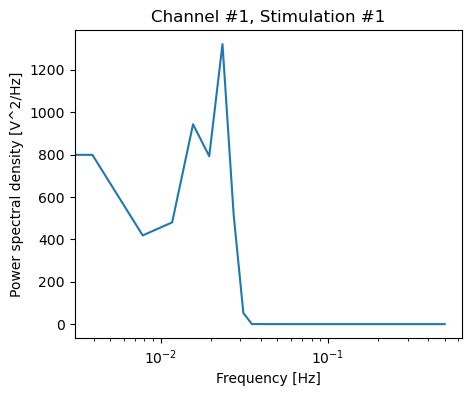

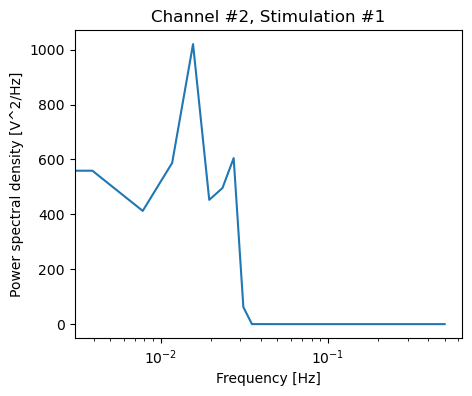

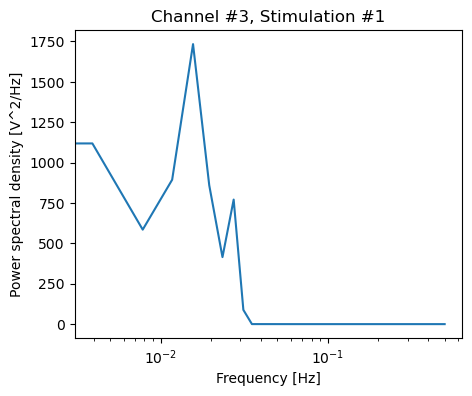

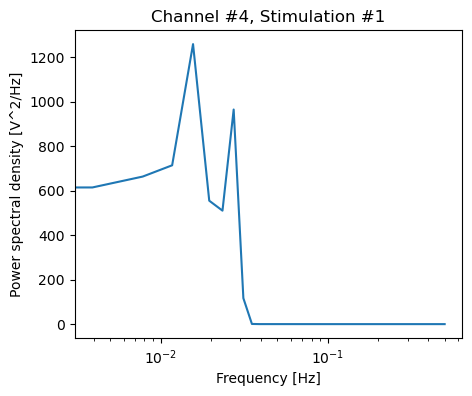

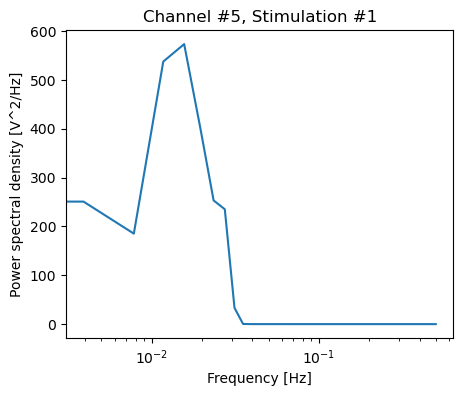

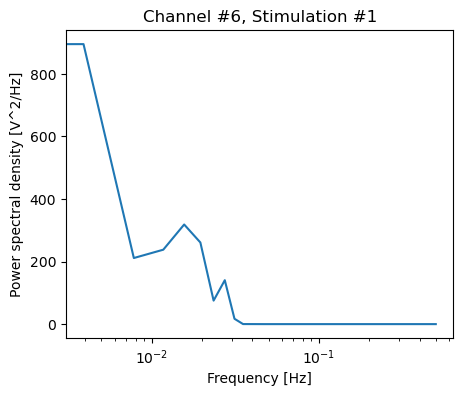

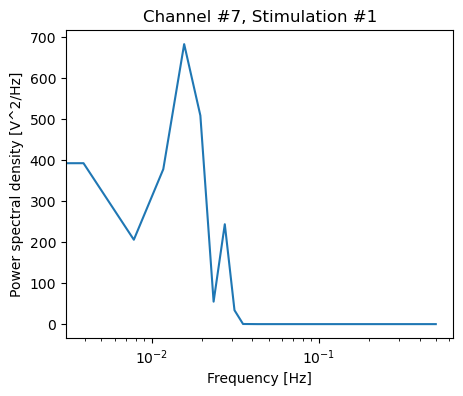

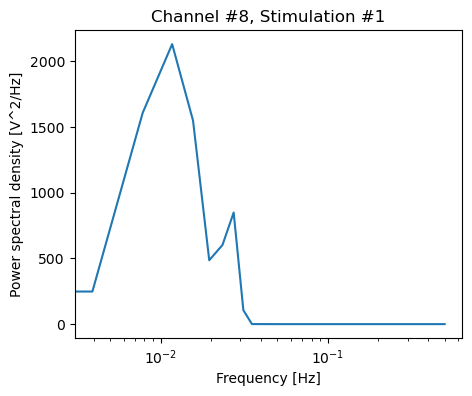

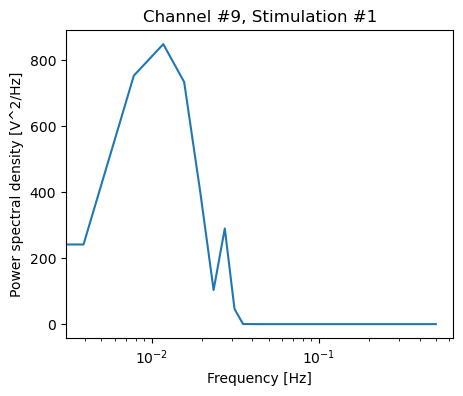

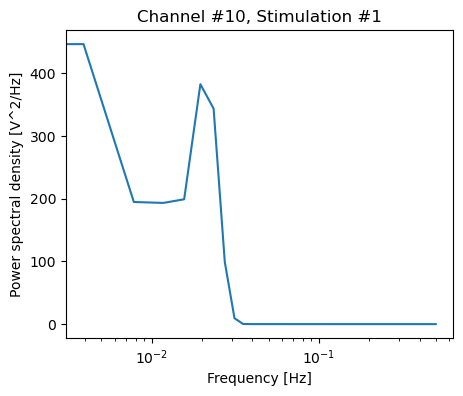

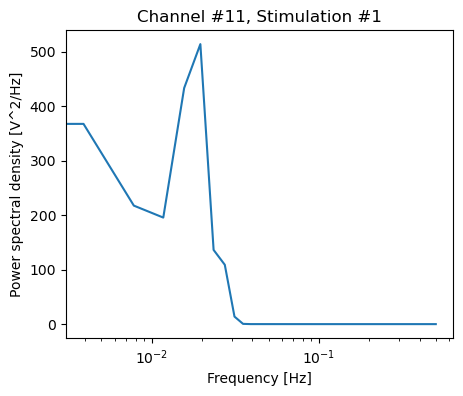

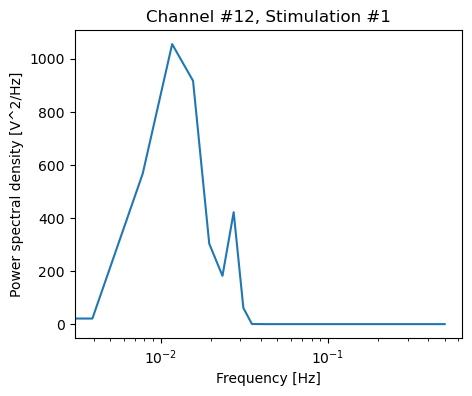

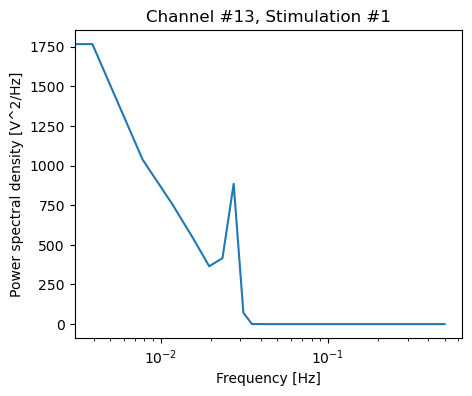

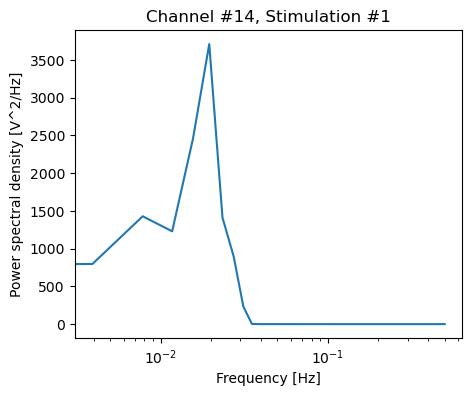

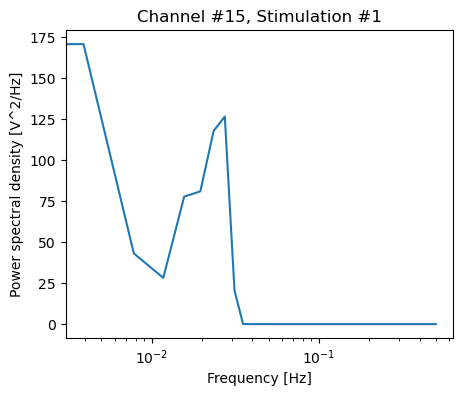

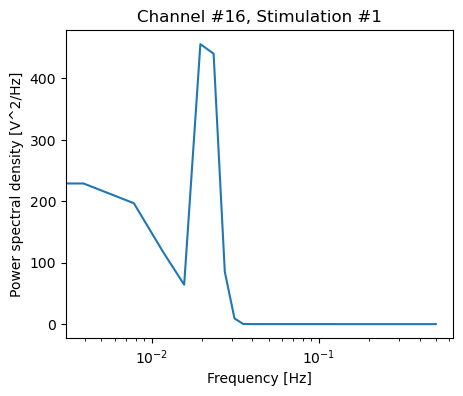

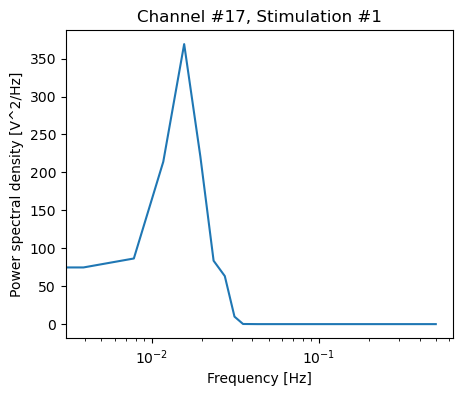

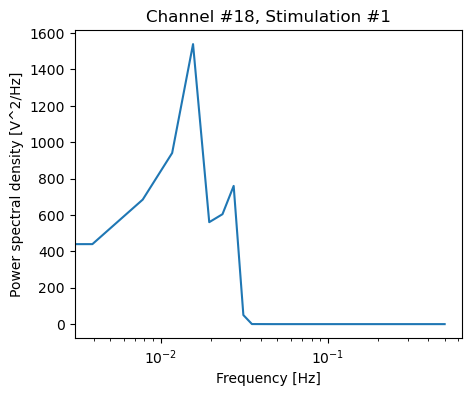

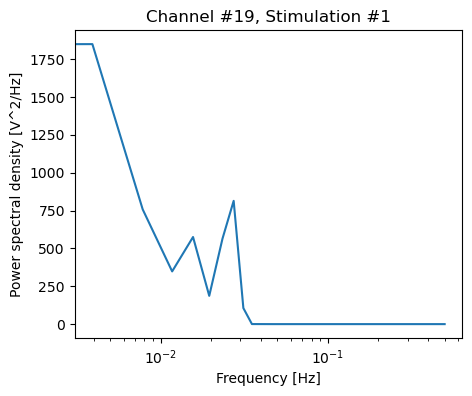

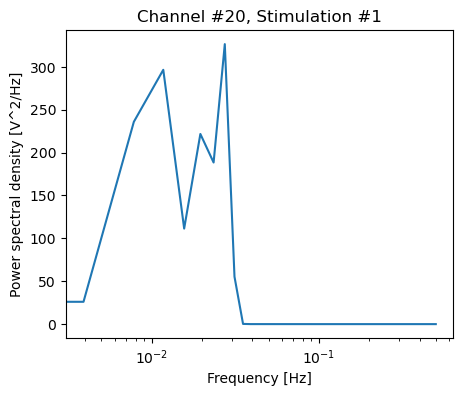

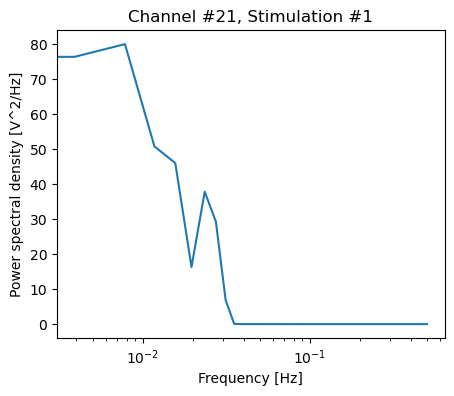

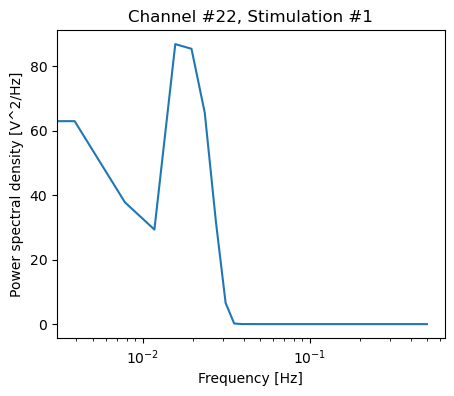

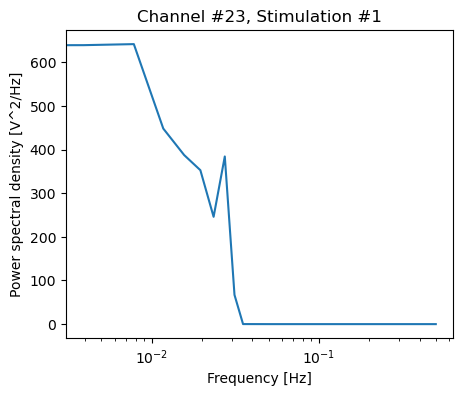

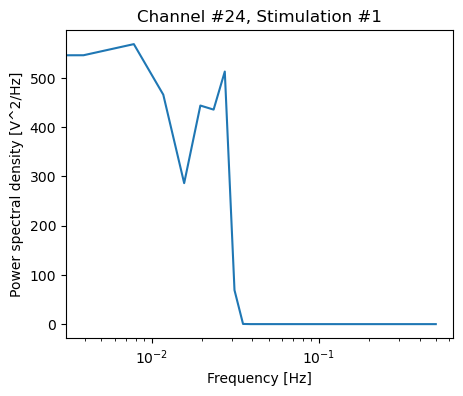

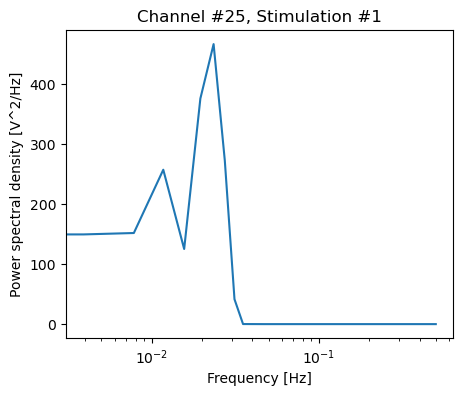

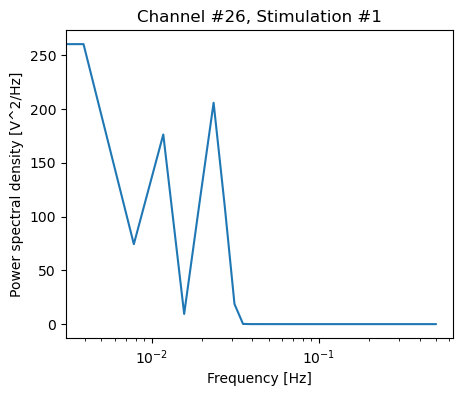

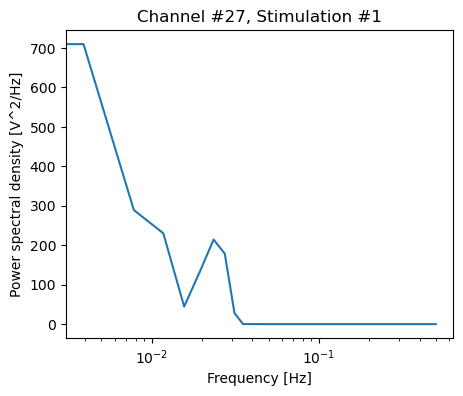

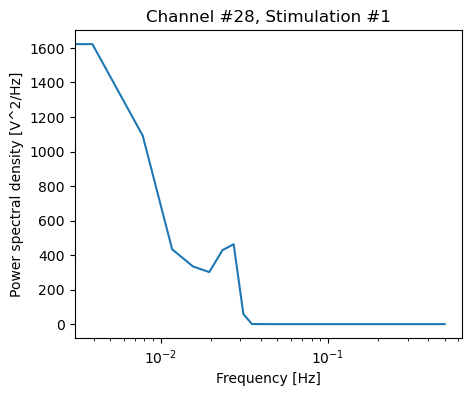

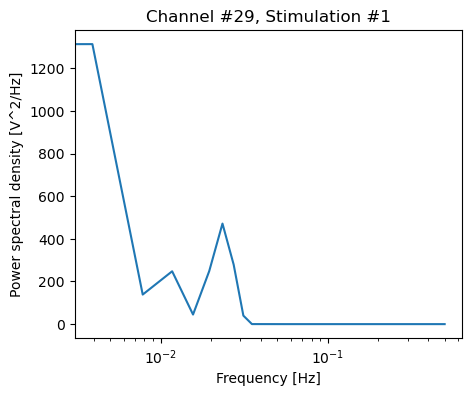

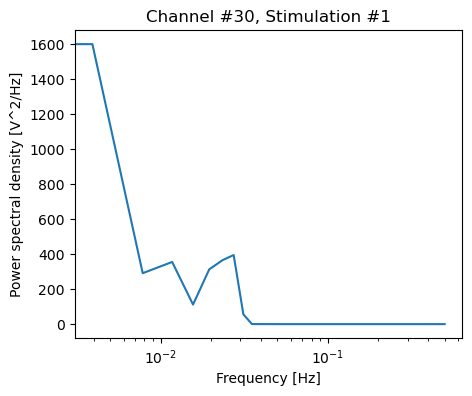

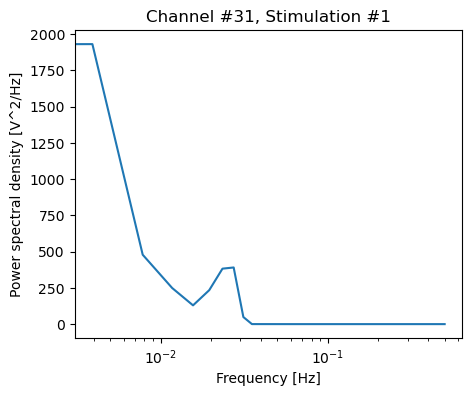

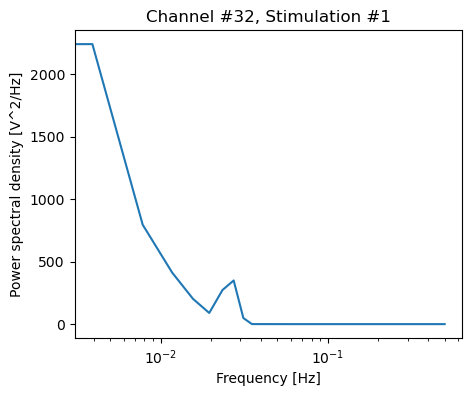

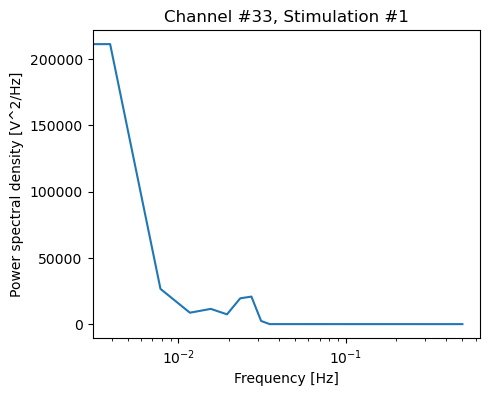

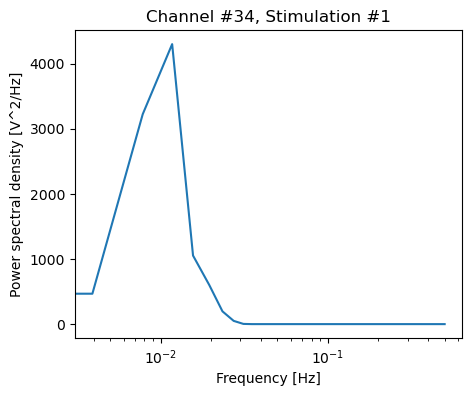

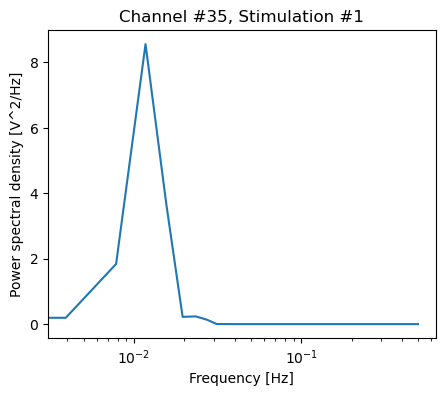

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Assuming the data is already loaded and the variables are defined.
# triggers = DSamp[0][0][0]
# EEGdata = DSamp[0][0][1]

# Identify indices where stimulation starts
stim_indices = np.where(triggers != 0)[0]

# We'll analyze an interval around the stimulation
interval = 1000  # Change this based on your needs

# Get the number of channels
num_channels = EEGdata.shape[0]

# Loop through all channels
for channel in range(num_channels):
    # Loop through stimulations
    for i, stim_index in enumerate(stim_indices):
        # Ensure the indices are within the bounds of the array
        start_index = max(0, stim_index - interval // 2)
        end_index = min(EEGdata.shape[1], stim_index + interval // 2)

        # Extract interval around stimulation
        stim_data = EEGdata[channel, start_index:end_index]

        # Check the data
        if stim_data.size > 0:
            # Let's look at the power spectrum in this interval
            freqs, psd = signal.welch(stim_data)

            # Plot
            plt.figure(figsize=(5, 4))
            plt.semilogx(freqs, psd)
            plt.title(f'Channel #{channel+1}, Stimulation #{i+1}')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Power spectral density [V^2/Hz]')
            plt.show()


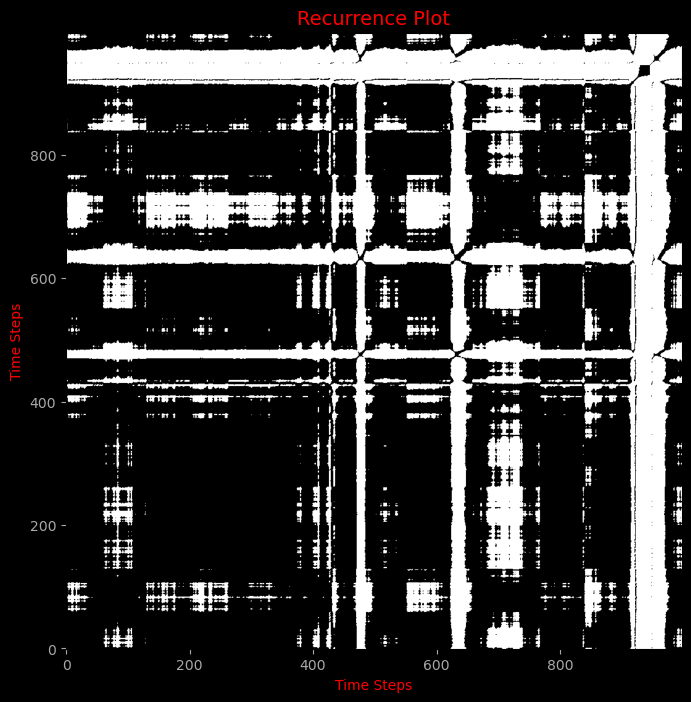

In [23]:
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot

# Downsample factor
downsample_factor = 10  # Further downsample the data

# Select a segment of the data
start_time = 1  # Adjust these to your needs
end_time = 10000

# Downsample the data and select a segment
downsampled_channel_data = EEGdata[0, start_time:end_time:downsample_factor]

# Create a RecurrencePlot object
rp = RecurrencePlot(dimension=embedding_dimension, time_delay=time_delay, threshold='distance')

# Transform the time series into a Recurrence Plot
X_rp = rp.fit_transform(downsampled_channel_data.reshape(1, -1))

# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))

# Set black background
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Draw the recurrence plot
im = ax.imshow(X_rp[0], cmap='binary', origin='lower')

# Set title and labels with red color
ax.set_title('Recurrence Plot', fontsize=14, color='red')
ax.set_xlabel('Time Steps', color='red')
ax.set_ylabel('Time Steps', color='red')

# Change ticks color to dark grey
ax.tick_params(colors='darkgrey')

# Show the plot
plt.show()


# Phase Space Plot

In [24]:
print(DSamp[0][0][1])


[[ 3.41060513e-13 -1.52575893e+00 -3.03097676e+00 ...  1.84934387e+01
   9.30284973e+00  1.73372428e-12]
 [ 2.04636308e-12 -1.23003046e+00 -2.44626127e+00 ...  1.02560191e+01
   5.15787044e+00  2.55795385e-12]
 [ 1.30739863e-12 -1.99174441e+00 -3.96201821e+00 ...  1.14589317e+01
   5.76268717e+00  1.27897692e-12]
 ...
 [-2.27373675e-13  5.24378357e+01  1.04297281e+02 ...  9.50083719e+00
   4.83121323e+00 -5.89750471e-13]
 [ 4.83169060e-13 -1.15790060e+00 -2.31070968e+00 ... -1.16364491e+00
  -5.89690364e-01  2.55795385e-13]
 [-3.99680289e-15 -5.95398748e-03 -1.22312086e-02 ...  2.41805975e+00
   1.21587560e+00 -3.44169138e-15]]


In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

channel_data = DSamp[0][0][1]

def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i+emb_dim*delay:delay] for i in range(N - emb_dim * delay + 1)])

def false_nearest_neighbors(data, emb_dim, delay, R=10):
    N = len(data)
    false_neighbors = np.zeros(emb_dim)

    for d in range(1, emb_dim + 1):
        emb_data = delay_embedding(data, d, delay)
        nbrs = NearestNeighbors(n_neighbors=2).fit(emb_data[:-delay])
        distances, indices = nbrs.kneighbors(emb_data[:-delay])
        neighbor_index = indices[:, 1]
        neighbor_distance = np.abs(data[neighbor_index + delay] - data[np.arange(N - d * delay) + delay])
        false_neighbors[d - 1] = np.mean((neighbor_distance / distances[:, 1]) > R)

    return false_neighbors

# Using this function:
def delay_embedding(data, emb_dim, delay):
    N = len(data)
    return np.array([data[i:i+emb_dim*delay:delay].flatten() for i in range(N - emb_dim * delay + 1)])

channel_data_flat = channel_data.flatten()
fnn = false_nearest_neighbors(channel_data_flat, emb_dim=10, delay=1)


# Plot the FNN as a function of embedding dimension
plt.figure()
plt.plot(np.arange(1, max_dim+1), fnn)
plt.xlabel('Embedding Dimension')
plt.ylabel('Fraction of False Nearest Neighbors')
plt.title('Estimation of Embedding Dimension using FNN Method')
plt.show()

/tmp/ipykernel_51108/3683520374.py:20: RuntimeWarning: divide by zero encountered in true_divide
  false_neighbors[d - 1] = np.mean((neighbor_distance / distances[:, 1]) > R)
/tmp/ipykernel_51108/3683520374.py:20: RuntimeWarning: invalid value encountered in true_divide
  false_neighbors[d - 1] = np.mean((neighbor_distance / distances[:, 1]) > R)


In [ ]:
# Print the results
for dim, fnn_fraction in enumerate(fnn, 1):
    print(f"Embedding dimension: {dim}, Fraction of false nearest neighbors: {fnn_fraction:.2f}")

NameError: name 'fnn' is not defined

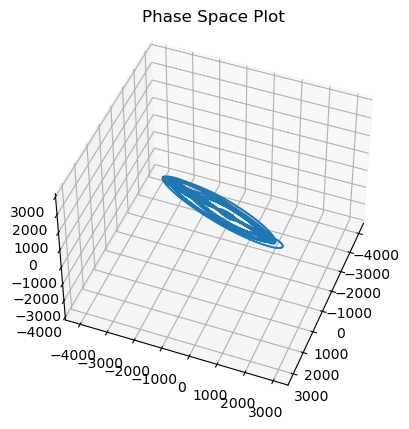

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define a function for delay embedding
def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Choose the first channel of your EEG data
channel_data = EEGdata[0, :]

# Perform delay embedding with embedding dimension 3 and delay 1
embedded_channel_data = delay_embedding(channel_data, emb_dim=3, delay=1)

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Change viewing angle
ax.view_init(elev=45, azim=21)

ax.plot(embedded_channel_data[:, 0], embedded_channel_data[:, 1], embedded_channel_data[:, 2])
plt.title('Phase Space Plot')
plt.show()


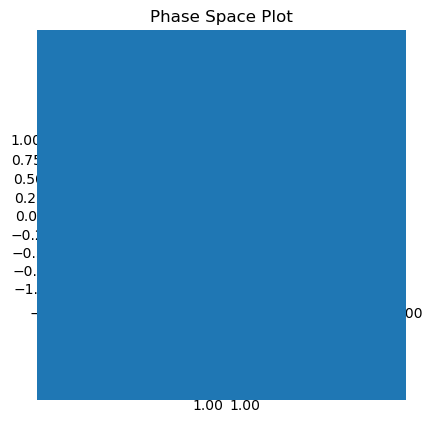

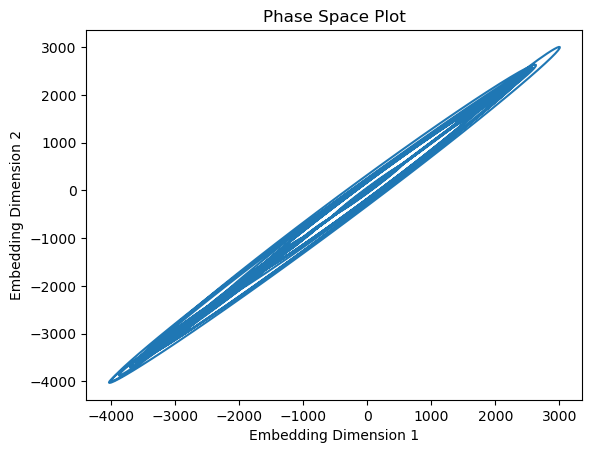

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function for delay embedding
def delay_embedding(data, emb_dim, delay):
    N = len(data)
    embedded_data = np.zeros((N - (emb_dim - 1) * delay, emb_dim))
    for i in range(N - (emb_dim - 1) * delay):
        embedded_data[i] = [data[i + j * delay] for j in range(emb_dim)]
    return embedded_data

# Choose the first channel of your EEG data
channel_data = EEGdata[0, :]

# Perform delay embedding with embedding dimension 2 and delay 1
embedded_channel_data = delay_embedding(channel_data, emb_dim=2, delay=1)

# Create 2D plot
plt.figure()
plt.plot(embedded_channel_data[:, 0], embedded_channel_data[:, 1])
plt.title('Phase Space Plot')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

# Recurrence Quantification Analysis II

In [89]:
print(events_list[0].dtype)


[('time', 'O'), ('offset', 'O'), ('code', 'O'), ('type', 'O'), ('Label', 'O'), ('StimType', 'O')]


In [90]:
print(events_list[0])


[[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64))
  (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[805.571]]), array([[805572]], dtype=int32), array(['0032'], dtyp

In [98]:
# Extract the structured array
events = data['DSamp'][0][0]

# Print the first element of 'events' to check its structure
print(events[0])





[[(array([[20.428]]), array([[20429]], dtype=uint16), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.442]]), array([[619443]], dtype=int32), array(['0002'], dtype='<U4'), array([[2]], dtype=uint8), array(['Block Start'], dtype='<U11'), array([], shape=(1, 0), dtype=float64))
  (array([[619.499]]), array([[619500]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[654.746]]), array([[654747]], dtype=int32), array(['0032'], dtype='<U4'), array([[32]], dtype=uint8), array(['Stim Stop'], dtype='<U9'), array([], shape=(1, 0), dtype=float64))
  (array([[770.515]]), array([[770516]], dtype=int32), array(['0016'], dtype='<U4'), array([[16]], dtype=uint8), array(['Stim Start'], dtype='<U10'), array(['M30'], dtype='<U3'))
  (array([[805.571]]), array([[805572]], dtype=int32), array(['0032'], dtyp

In [100]:
# Initialize lists to hold labels and times
labels = []
times = []

# Extract labels and times
for event in events:
    for subevent in event[0]:
        time, _, _, _, label, _ = subevent
        labels.append(label[0])
        times.append(time[0][0])

# Convert lists to numpy arrays for possible further computations
labels = np.array(labels)
times = np.array(times)


TypeError: cannot unpack non-iterable numpy.float64 object

In [94]:


# Extract the structured array
events = data['DSamp'][0][0]

# Initialize lists to hold start and stop times for both stimulations and blocks
stim_start_times = []
stim_stop_times = []
block_start_times = []

# Loop over all events
for event in events:
    event_desc = event['Label'][0]  # Extract 'Label' from the structured array
    event_time = event['time'][0][0]  # Extract 'time' from the structured array
    if event_desc == 'Stim Start':
        stim_start_times.append(event_time)  # Add stim start time
    elif event_desc == 'Stim Stop':
        stim_stop_times.append(event_time)  # Add stim stop time
    elif event_desc == 'Block Start':
        block_start_times.append(event_time)  # Add block start time

# Convert lists to numpy arrays for possible further computations
stim_start_times = np.array(stim_start_times)
stim_stop_times = np.array(stim_stop_times)
block_start_times = np.array(block_start_times)




ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [83]:
# Function for downsampling
def downsample(data, downsample_factor):
    return data[::downsample_factor]

# Define the downsample factor
downsample_factor = 100000

# Initialize a list to hold the RQA measures for each channel
rqa_measures_list = []

# Loop over each channel
for channel_data in EEGdata:

    # Downsample the data
    downsampled_channel_data = downsample(channel_data, downsample_factor)

    # Compute the recurrence plot for this channel
    rp = RecurrencePlot(dimension=embedding_dimension, time_delay=time_delay, threshold='distance')
    recurrence_plot = rp.fit_transform(downsampled_channel_data.reshape(1, -1))

    # Compute the RQA measures for this channel
    determinism, recurrence_rate, average_diag_line = calculate_rqa_measures(recurrence_plot[0])

    # Store the RQA measures in a dictionary and add it to the list
    rqa_measures = {
        'determinism': determinism,
        'recurrence_rate': recurrence_rate,
        'average_diag_line': average_diag_line
    }
    rqa_measures_list.append(rqa_measures)


In [72]:
# Define TES stimulation parameters
stimulation_params = {
    "frequency": 10,  # Hz
    "amplitude": 1.5,  # mA
    "duration": 5  # minutes
}

# Initialize an empty list to hold the Higuchi Fractal Dimension for each channel
fd_list = []

# Calculate the fractal dimension of each channel of the EEG data using Higuchi Fractal Dimension
for channel in EEGdata:
    channel = np.ascontiguousarray(channel)  # convert the memory layout to 'C' style
    fd = higuchi_fd(channel)
    fd_list.append(fd)

# Create a RecurrencePlot object from EEG data
rp = RecurrencePlot(EEGdata)

# Compute some RQA measures
rqa_measures = {
    'determinism': rp.determinism(),
    'recurrence_rate': rp.recurrence_rate(),
    'average_diag_line': rp.average_diag_line()
}

# Apply TES stimulation
stimulation_duration = stimulation_params["duration"] * 60  # Convert to seconds
stimulation_frequency = stimulation_params["frequency"]
stimulation_amplitude = stimulation_params["amplitude"]
stimulation_waveform = stimulation_amplitude * np.sin(2 * np.pi * stimulation_frequency * np.arange(stimulation_duration))

AttributeError: 'RecurrencePlot' object has no attribute 'determinism'

In [75]:
# Initialize a list to hold the RQA measures for each channel
rqa_measures_list = []

# Loop over each channel
for channel_data in EEGdata:

    # Compute the recurrence plot for this channel
    rp = RecurrencePlot(dimension=embedding_dimension, time_delay=time_delay, threshold='distance')
    recurrence_plot = rp.fit_transform(channel_data.reshape(1, -1))

    # Compute the RQA measures for this channel
    determinism, recurrence_rate, average_diag_line = calculate_rqa_measures(recurrence_plot[0])

    # Store the RQA measures in a dictionary and add it to the list
    rqa_measures = {
        'determinism': determinism,
        'recurrence_rate': recurrence_rate,
        'average_diag_line': average_diag_line
    }
    rqa_measures_list.append(rqa_measures)


MemoryError: Unable to allocate 390. TiB for an array with shape (1, 4227786, 4227786, 3) and data type float64

In [74]:
# Define a function to calculate determinism, recurrence_rate, and average_diag_line
def calculate_rqa_measures(recurrence_plot):
    diagonal_lengths = []
    total_recurrences = 0
    determinism_recurrences = 0

    for i in range(recurrence_plot.shape[0]):
        for j in range(recurrence_plot.shape[1]):
            if recurrence_plot[i, j] == 1:
                total_recurrences += 1
                if i > 0 and j > 0 and recurrence_plot[i-1, j-1] == 1:
                    length = 2
                    while (i-length >= 0 and j-length >= 0 and recurrence_plot[i-length, j-length] == 1):
                        length += 1
                    if length > 2:
                        diagonal_lengths.append(length)
                        determinism_recurrences += length

    determinism = determinism_recurrences / total_recurrences
    recurrence_rate = total_recurrences / (recurrence_plot.shape[0] * recurrence_plot.shape[1])
    average_diag_line = sum(diagonal_lengths) / len(diagonal_lengths)

    return determinism, recurrence_rate, average_diag_line

# Create a RecurrencePlot object from EEG data
rp = RecurrencePlot(dimension=embedding_dimension, time_delay=time_delay, threshold='distance')
recurrence_plot = rp.fit_transform(EEGdata)

# Compute some RQA measures
determinism, recurrence_rate, average_diag_line = calculate_rqa_measures(recurrence_plot)
rqa_measures = {
    'determinism': determinism,
    'recurrence_rate': recurrence_rate,
    'average_diag_line': average_diag_line
}


MemoryError: Unable to allocate 13.3 PiB for an array with shape (35, 4227786, 4227786, 3) and data type float64

In [ ]:
# Add TES stimulation to the EEG data
eeg_data_with_stimulation = eeg_data + stimulation_waveform

# Calculate RQA measures for the EEG data with TES stimulation
rqa_measures_with_stimulation = rqa(eeg_data_with_stimulation)

# Calculate the fractal dimension of the EEG data with TES stimulation
fd_with_stimulation = pyeeg.pfd(eeg_data_with_stimulation)

# Visualize the results
plt.subplot(2, 2, 1)
plt.plot(eeg_data)
plt.title("EEG data")

plt.subplot(2, 2, 2)
plt.plot(stimulation_waveform)
plt.title("TES stimulation")

plt.subplot(2, 2, 3)
plt.plot(eeg_data_with_stimulation)
plt.title("EEG data with TES stimulation")

plt.subplot(2, 2, 4)
plt.bar(range(len(rqa_measures)), rqa_measures)
plt.bar(range(len(rqa_measures_with_stimulation)), rqa_measures_with_stimulation)
plt.title("RQA measures")

plt.show()

print("Fractal dimension of EEG data:", fd)
print("Fractal dimension of EEG data with TES stimulation:", fd_with_stimulation)

# Multifractal Analysis

In [ ]:
import numpy as np
from nolds import mfdfa
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Load EEG data
eeg_data = np.loadtxt("eeg_data.txt")

# Define TES stimulation parameters
stimulation_params = {
    "frequency": 10,  # Hz
    "amplitude": 1.5,  # mA
    "duration": 5  # minutes
}

# Filter the EEG data
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

fs = 1000  # Hz
lowcut = 1  # Hz
highcut = 40  # Hz

eeg_data_filtered = butter_bandpass_filter(eeg_data, lowcut, highcut, fs)

In [ ]:
# Calculate multifractal spectrum for the EEG data
alpha, f_alpha = mfdfa(eeg_data_filtered)

# Calculate multifractal spectrum for the EEG data with TES stimulation
stimulation_duration = stimulation_params["duration"] * 60  # Convert to seconds
stimulation_frequency = stimulation_params["frequency"]
stimulation_amplitude = stimulation_params["amplitude"]
stimulation_waveform = stimulation_amplitude * np.sin(2 * np.pi * stimulation_frequency * np.arange(stimulation_duration))

eeg_data_with_stimulation = eeg_data_filtered + stimulation_waveform
alpha_with_stimulation, f_alpha_with_stimulation = mfdfa(eeg_data_with_stimulation)

# Visualize the results
plt.subplot(2, 2, 1)
plt.plot(eeg_data)
plt.title("EEG data")

plt.subplot(2, 2, 2)
plt.plot(stimulation_waveform)
plt.title("TES stimulation")

plt.subplot(2, 2, 3)
plt.plot(eeg_data_with_stimulation)
plt.title("EEG data with TES stimulation")

plt.subplot(2, 2, 4)
plt.plot(alpha, f_alpha, label="EEG data")
plt.plot(alpha_with_stimulation, f_alpha_with_stimulation, label="EEG data with TES stimulation")
plt.legend()
plt.title("Multifractal spectrum")

plt.show()

# Phase Synchonization Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Load EEG data
eeg_data = np.loadtxt("eeg_data.txt")

# Define TES stimulation parameters
stimulation_params = {
    "frequency": 10,  # Hz
    "amplitude": 1.5,  # mA
    "duration": 5  # minutes
}

# Calculate phase synchronization for the EEG data and TES stimulation
sampling_rate = 1000  # Hz
eeg_phase = np.angle(hilbert(eeg_data))

stimulation_frequency = stimulation_params["frequency"]
stimulation_duration = stimulation_params["duration"] * 60  # Convert to seconds
stimulation_waveform = stimulation_params["amplitude"] * np.sin(2 * np.pi * stimulation_frequency * np.arange(stimulation_duration))

stimulation_phase = np.angle(hilbert(stimulation_waveform))

# Compute the phase difference between EEG data and TES stimulation
phase_diff = np.angle(np.exp(1j * (stimulation_phase - eeg_phase)))

# Calculate the phase synchronization
sync_strength = np.abs(np.mean(np.exp(1j * phase_diff)))

# Visualize the results
plt.subplot(2, 2, 1)
plt.plot(eeg_data)
plt.title("EEG data")

plt.subplot(2, 2, 2)
plt.plot(stimulation_waveform)
plt.title("TES stimulation")

plt.subplot(2, 2, 3)
plt.plot(phase_diff)
plt.title("Phase difference")

plt.subplot(2, 2, 4)
plt.bar([0, 1], [1 - sync_strength, sync_strength])
plt.xticks([0, 1], ["Desynchronized", "Synchronized"])
plt.title("Phase synchronization")

plt.show()

print("Phase synchronization strength:", sync_strength)

# Nonlinear Forecasting

In [ ]:
import numpy as np
from nolds import lyap_e, pfd
from pyts.approximation import SymbolicAggregateApproximation
from pyts.datasets import load_gunpoint
from pyts.multivariate.image import JointRecurrencePlot
from pyts.multivariate.transformation import MultivariateTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


# Load EEG data
eeg_data = np.loadtxt("eeg_data.txt")

# Define TES stimulation parameters
stimulation_params = {
    "frequency": 10,  # Hz
    "amplitude": 1.5,  # mA
    "duration": 5  # minutes
}

# Apply TES stimulation
stimulation_duration = stimulation_params["duration"] * 60  # Convert to seconds
stimulation_frequency = stimulation_params["frequency"]
stimulation_amplitude = stimulation_params["amplitude"]
stimulation_waveform = stimulation_amplitude * np.sin(2 * np.pi * stimulation_frequency * np.arange(stimulation_duration))

# Add TES stimulation to the EEG data
eeg_data_with_stimulation = eeg_data + stimulation_waveform

# Calculate the fractal dimension of the EEG data with TES stimulation
fd_with_stimulation = pfd(eeg_data_with_stimulation)

# Apply nonlinear forecasting using Takens' embedding theorem
tau = 10
embedding_dimension = 3
X = np.array([eeg_data_with_stimulation[i:i + embedding_dimension] for i in range(0, len(eeg_data_with_stimulation) - embedding_dimension - tau, tau)])
y = eeg_data_with_stimulation[embedding_dimension + tau:len(eeg_data_with_stimulation):tau]

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use symbolic aggregate approximation to transform the data
n_bins = 4
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='uniform')
X_train_sax = sax.fit_transform(X_train)
X_test_sax = sax.transform(X_test)

# Use joint recurrence plot to transform the data
n_neighbors = 2
threshold = 0.1
weights = 'distance'
jrp = JointRecurrencePlot(n_neighbors=n_neighbors, threshold=threshold, weights=weights)
X_train_jrp = jrp.fit_transform(X_train_sax)
X_test_jrp = jrp.transform(X_test_sax)

# Use multivariate transformation to transform the data
mt = MultivariateTransformer(norm_mean=True, norm_std=True)
X_train_mt = mt.fit_transform(X_train_jrp)
X_test_mt = mt.transform(X_test_jrp)

# Train a K-nearest neighbors regression model
n_neighbors = 10
weights = 'distance'
knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
knn.fit(X_train_mt, y_train)

# Make predictions using the trained model
y_pred = knn.predict(X_test_mt)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)

# Transfer Entropy

In [ ]:
import numpy as np
from nolitsa import surrogates, data, te
import matplotlib.pyplot as plt

# Load EEG data
eeg_data = np.loadtxt("eeg_data.txt")

# Define TES stimulation parameters
stimulation_params = {
    "frequency": 10,  # Hz
    "amplitude": 1.5,  # mA
    "duration": 5  # minutes
}

# Apply TES stimulation
stimulation_duration = stimulation_params["duration"] * 60  # Convert to seconds
stimulation_frequency = stimulation_params["frequency"]
stimulation_amplitude = stimulation_params["amplitude"]
stimulation_waveform = stimulation_amplitude * np.sin(2 * np.pi * stimulation_frequency * np.arange(stimulation_duration))

# Define time delay and embedding dimension for TE analysis
tau = 10
m = 3

# Generate surrogate data for TE analysis
surrogate_eeg_data = surrogates.iaaft(eeg_data)
surrogate_stimulation_waveform = surrogates.iaaft(stimulation_waveform)

# Calculate transfer entropy from TES to EEG
te_stim_to_eeg = te.te_compute(surrogate_eeg_data, surrogate_stimulation_waveform, tau=tau, m=m)

# Visualize the results
plt.subplot(2, 2, 1)
plt.plot(eeg_data)
plt.title("EEG data")

plt.subplot(2, 2, 2)
plt.plot(stimulation_waveform)
plt.title("TES stimulation")

plt.subplot(2, 2, 3)
plt.plot(eeg_data + stimulation_waveform)
plt.title("EEG data with TES stimulation")

plt.subplot(2, 2, 4)
plt.imshow(te_stim_to_eeg, cmap='jet', origin='lower', aspect='auto')
plt.title("Transfer entropy (TES to EEG)")
plt.xlabel("TES signal")
plt.ylabel("EEG signal")

plt.show()

# Bifurcation Analysis

In [ ]:
import PyDSTool as dst
import numpy as np
import matplotlib.pyplot as plt

# Define the Izhikevich model
def izhikevich_model(a, b, c, d):
    def rhs(x, t, pars):
        v, u = x
        I = pars['I']
        dv = 0.04 * v**2 + 5 * v + 140 - u + I
        du = a * (b * v - u)
        return np.array([dv, du])

    return rhs

# Parameters for the Izhikevich model
a = 0.02
b = 0.2
c = -65
d = 8

# Define the PyDSTool model
rhs = izhikevich_model(a, b, c, d)
DSargs = dst.args()
DSargs.name = 'Izhikevich'
DSargs.ics = {'v': c, 'u': b * c}
DSargs.pars = {'I': 10, 'a': a, 'b': b, 'c': c, 'd': d}
DSargs.tdomain = [0, 100]
DSargs.varspecs = {'v': '0.04 * v**2 + 5 * v + 140 - u + I', 'u': 'a * (b * v - u)'}
DSargs.pdomain = {'I': [0, 20]}
DSargs.xdomain = {'v': [-100, 100], 'u': [-30, 30]}
DSargs.algparams = {'init_step': 0.01, 'max_step': 0.01}
DSargs.checklevel = 2
DSargs.fnspecs = {'reset': (['v', 'u'], 'p["c"], u + p["d"]')}

izhikevich = dst.Vode_ODEsystem(DSargs)

# Bifurcation analysis
PC = dst.ContClass(izhikevich)
PCargs = dst.args(name='EQ1', type='EP-C', freepars=['I'], MaxNumPoints=500, MinStepSize=1e-5, MaxStepSize=1e-3)
PC.newCurve(PCargs)
PC.curves['EQ1'].backward()
PC.curves['EQ1'].forward()

# Plot bifurcation diagram
PC.display(coords=('I', 'v'))
plt.xlabel('I')
plt.ylabel('v')
plt.title('Bifurcation Diagram')
plt.grid()
plt.show()

In [ ]:
# Define the differential equations
def vanderpol_rhs(x, y, mu):
    dxdt = y
    dydt = mu * (1 - x**2) * y - x
    return (dxdt, dydt)

# Parameters for the Van der Pol oscillator
mu = 2.0

In [ ]:
# Define the PyDSTool model
DSargs = dst.args(name='vanderpol')
DSargs.pars = {'mu': mu}
DSargs.varspecs = {'x': 'y', 'y': 'mu * (1 - x**2) * y - x'}
DSargs.ics = {'x': 1, 'y': 1}
DSargs.tdomain = [0, 100]

ode = dst.Generator.Vode_ODEsystem(DSargs)

In [ ]:
# Bifurcation analysis
PC = dst.ContClass(ode)
name1 = 'EQ1'
PCargs = dst.args(name=name1)
PCargs.type = 'EP-C'
PCargs.freepars = ['mu']
PCargs.StepSize = 1e-3
PCargs.MaxNumPoints = 800
PCargs.MaxStepSize = 1e-2
PCargs.MinStepSize = 1e-6
PCargs.MaxTestIters = 40
PCargs.LocBifPoints = 'all'
PCargs.SaveEigen = True
PCargs.StopAtPoints = ['B']

PC.newCurve(PCargs)
PC.curves[name1].backward()
PC.curves[name1].forward()

PC.display(['mu'], stability=True, linewidth=2)
plt.xlabel('mu')
plt.ylabel('x')
plt.title('Bifurcation Diagram')
plt.grid()
plt.show()

# Hermitian 

In [ ]:
import numpy as np

def wave_function(data):
    return np.exp(-1j * data)

def hermitian_operator(data):
    return np.conj(data).T

def expectation_value(state, operator, state_conj):
    return np.sum(np.vdot(state_conj, np.dot(operator, state)))

# Load your EEG data
# eeg_data should be a numpy array with shape (n_channels, n_samples)
# For the purpose of this example, we'll create a random dataset
n_channels = 32
n_samples = 1000
eeg_data = np.random.rand(n_channels, n_samples)

# Apply the wave function to the EEG data
quantum_states = wave_function(eeg_data)

# Calculate the Hermitian operator of the EEG data
hermitian_op = hermitian_operator(eeg_data)

# Calculate the expectation value of the Hermitian operator with respect to the quantum states
quantum_states_conj = np.conj(quantum_states)
exp_val = np.empty(n_channels, dtype=np.complex128)

for ch in range(n_channels):
    exp_val[ch] = expectation_value(quantum_states[ch], hermitian_op[ch], quantum_states_conj[ch])

# exp_val now contains the expectation value of the Hermitian operator for each channel, which can be used for further analysis
print("Expectation value:", exp_val)

# Cable Theory-Based Models, Compartmental Neuron Models, Network Models, Mean-Field Models, Detailed Biophysical Models, Realistic Head Models

# Graph Theory, Topological Data Analysis

# Particle Swarm Optimization

In [ ]:
# Define the PSO optimizer
def optimize_nn(x, y):
    n_input = x.shape[1]
    n_output = y.shape[1]
    n_hidden_layer1 = int(x.shape[1]/2)
    n_hidden_layer2 = int(x.shape[1]/4)

    def create_model():
        model = keras.models.Sequential([
            keras.layers.Dense(n_hidden_layer1, input_shape=[n_input], activation=activation_1),
            keras.layers.Dense(n_hidden_layer2, activation=activation_2),
            keras.layers.Dense(n_output, activation=activation_3)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_1)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    model = create_model()
    history = model.fit(x, y, epochs=50, verbose=0)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    return -r2

# Define the PSO optimizer
def optimize_nn(x, y):
    n_input = x.shape[1]
    n_output = y.shape[1]
    n_hidden_layer1 = int(x.shape[1]/2)
    n_hidden_layer2 = int(x.shape[1]/4)

    def create_model():
        model = keras.models.Sequential([
            keras.layers.Dense(n_hidden_layer1, input_shape=[n_input], activation=activation_1),
            keras.layers.Dense(n_hidden_layer2, activation=activation_2),
            keras.layers.Dense(n_output, activation=activation_3)
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_1)
        model.compile(loss='mean_squared_error', optimizer=optimizer)
        return model

    model = create_model()
    history = model.fit(x, y, epochs=50, verbose=0)
    y_pred = model.predict(x)
    r2 = r2_score(y, y_pred)
    return -r2

# Define inputs and outputs for the neural network
x = eeg_data_with_stimulation
y = electrical_stimulation_waveform.reshape(-1, 1)

# Define the PSO optimizer
optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=x.shape[1],
                                    options={'c1': 0.5, 'c2': 0.3, 'w':0.9},
                                    bounds=[(-1, 1)] * x.shape[1])

# Run the PSO optimizer
cost, pos = optimizer.optimize(optimize_nn, iters=max_iterations, x=x, y=y)

# Train the neural network with the optimized hyperparameters
model = optimize_nn(x, y)

# Make predictions with the trained neural network
y_pred = model.predict(x)